# **Final Project IRWAs**


Authors: <font color="blue">Lida Calsamiglia, Patricia Castelijns, Francesca Mees</font>

NIAs:<font color="blue"> 231319, 229651, 230849<font>

Date: <font color="blue">21/10/2023</font>

In [ ]:
# If running in Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import json
import nltk
import matplotlib.pyplot as plt
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import collections
from numpy import linalg as la
import re
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import networkx as nx
from nltk.sentiment import SentimentIntensityAnalyzer
from datetime import datetime
from datetime import date, timedelta, datetime, time, tzinfo

# **Part 1: Text Processing and Exploratory Data Analysis**


#### Load Python packages
Let's first import all the needed packages

#### Load data into memory
The data ids is stored in the CSV file, and JSON file it contains a set of tweets related to the Russo- Ukrainian War. In the CSV file each tweet has document id and id separated by "\t" character. In the JSON file we loaded 176 variable such as created_at, id, id_str...

In [ ]:
df_csv = pd.read_csv('/content/drive/Shareddrives/IRWA/part2/Rus_Ukr_war_data_ids.csv',sep='\t', header=None)
df_csv.columns = ['doc_id','id']
df_csv.head()

,doc_id,id
0,doc_1,1575918221013979136
1,doc_2,1575918081461080065
2,doc_3,1575917992390823936
3,doc_4,1575917907774967809
4,doc_5,1575917878410301441


In [ ]:
# Load JSON data from a file

data = []
with open('/content/drive/Shareddrives/IRWA/part2/Rus_Ukr_war_data.json', 'r') as file:
    for line in file:
        try:
            # Parse each line as a JSON object
            json_data = json.loads(line)
            data.append(json_data)
        except json.JSONDecodeError:
            print(f"Invalid JSON: {line}")


# Convert JSON data to a pandas DataFrame
json_df = pd.json_normalize(data)


In [ ]:
json_df.head()

,created_at,id,id_str,full_text,truncated,display_text_range,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,...,quoted_status.place.place_type,quoted_status.place.name,quoted_status.place.full_name,quoted_status.place.country_code,quoted_status.place.country,quoted_status.place.contained_within,quoted_status.place.bounding_box.type,quoted_status.place.bounding_box.coordinates,withheld_in_countries,quoted_status.scopes.followers
0,Fri Sep 30 18:39:17 +0000 2022,1575918221013979136,1575918221013979136,@MelSimmonsFCDO Wrong. Dictator Putin's Fascis...,False,"[16, 149]","<a href=""http://twitter.com/download/android"" ...",1.575767e+18,1575766913334251520,8.270929e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fri Sep 30 18:38:44 +0000 2022,1575918081461080065,1575918081461080065,🇺🇦❤️ The Armed Forces liberated the village of...,False,"[0, 265]","<a href=""http://twitter.com/download/android"" ...",NaN,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Fri Sep 30 18:38:23 +0000 2022,1575917992390823936,1575917992390823936,ALERT 🚨Poland preps anti-radiation tablets ove...,False,"[0, 133]","<a href=""http://twitter.com/download/android"" ...",NaN,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fri Sep 30 18:38:03 +0000 2022,1575917907774967809,1575917907774967809,I’m still waiting for my google map 🗺️ to upda...,False,"[0, 151]","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Fri Sep 30 18:37:56 +0000 2022,1575917878410301441,1575917878410301441,@EmmanuelMacron probably you're right or you h...,False,"[16, 157]","<a href=""https://mobile.twitter.com"" rel=""nofo...",1.575906e+18,1575906157088370688,1.976143e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print("Total number of tweets in the corpus (which is a set of tweets related to the Russo- Ukrainian War):", len(json_df))

Total number of tweets in the corpus (which is a set of tweets related to the Russo- Ukrainian War): 4000


### Pre-process the tweets

We define a function that takes a tweet and performs the following operations:


*   Transform all text to lowercase
*   Tokenize the text to get a list of terms
*   Remove stop words
*   Removing punctuation marks
*   Stem terms
*   Removing URLs, both "http" and "https" ones.

In [ ]:
nltk.download('stopwords')
def preprocess_tweet(tweet, stemming, split):
    """
    Preprocess the tweet removing stop words, stemming,
    transforming in lowercase and return the tokens of the text.

    Argument:
    tweet to be preprocessed

    Returns:
    tweet - a list of tokens corresponding to the input text after the preprocessing
    """

    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))
    tweet = re.sub(r'https\S+','',tweet) # Removing URLs, both "http" and "https" ones.
    tweet = re.sub(r'http\S+','',tweet) # Removing URLs, both "http" and "https" ones.
    tweet = tweet.lower() ## Transform in lowercase
    tweet = re.sub(r'[^\w\s@#]', '', tweet) # Remove punctuation marks except @,#
    tweet = re.sub(r'#\S+', '', tweet) # Remove hashtags

    if split:
      tweet = tweet.split() ## Tokenize the text to get a list of terms
      tweet = [word for word in tweet if word not in stop_words]  # Eliminate the stopwords
    if stemming:
      tweet = [stemmer.stem(word) for word in tweet] # Perform stemming

    return tweet

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Create new column with the text of the tweets preprocessed
json_df['preprocessed_text'] = json_df['full_text'].apply(lambda x: preprocess_tweet(x,stemming=True, split=True))

In [ ]:
# Add columns of interest: hashtags and tweet url
json_df['tweet_url'] = np.nan * len(json_df)
for tweet in range(len(json_df)):
    media_tweet = json_df.at[tweet, 'entities.media']

    if pd.notna(media_tweet) and len(media_tweet) > 0:
        json_df.at[tweet, 'tweet_url'] = media_tweet[0]['url']
    else:
        json_df.at[tweet, 'tweet_url'] = 'no url'

hashtags = []
for tweet in range(len(json_df)):
  hashtags.append([item['text'] for item in json_df['entities.hashtags'][tweet]])

json_df['hashtags'] = hashtags

### Define dataframes

In [ ]:
final_df = json_df[['created_at','id','full_text', 'preprocessed_text', 'favorite_count', 'retweet_count','hashtags',  'tweet_url']]
analytics_df = json_df[['created_at','id', 'full_text', 'preprocessed_text', 'favorite_count', 'retweet_count','hashtags']].copy()

In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   created_at         4000 non-null   object
 1   id                 4000 non-null   int64 
 2   full_text          4000 non-null   object
 3   preprocessed_text  4000 non-null   object
 4   favorite_count     4000 non-null   int64 
 5   retweet_count      4000 non-null   int64 
 6   hashtags           4000 non-null   object
 7   tweet_url          4000 non-null   object
dtypes: int64(3), object(5)
memory usage: 250.1+ KB


In [ ]:
pd.set_option('max_colwidth', None)
final_df.head(3)

,created_at,id,full_text,preprocessed_text,favorite_count,retweet_count,hashtags,tweet_url
0,Fri Sep 30 18:39:17 +0000 2022,1575918221013979136,@MelSimmonsFCDO Wrong. Dictator Putin's Fascist Russia intends to conquer as much Ukrainian Land as possible.\n#RussiainvadesUkraine\n#UkraineRussiaWar,"[@melsimmonsfcdo, wrong, dictat, putin, fascist, russia, intend, conquer, much, ukrainian, land, possibl]",0,0,"[RussiainvadesUkraine, UkraineRussiaWar]",no url
1,Fri Sep 30 18:38:44 +0000 2022,1575918081461080065,🇺🇦❤️ The Armed Forces liberated the village of #Drobysheve of the #Lymansk urban territorial community in #Donetsk region.#UkraineRussiaWar\n#UkraineWar #Ukraine️ #UkraineWillWin #UkrainianArmy #ukrainecounteroffensive #UkraineWarNews #SlavaUkraïni #StandWithUkraine https://t.co/ifg0RXDMBQ,"[arm, forc, liber, villag, urban, territori, commun, region]",0,0,"[Drobysheve, Lymansk, Donetsk, UkraineRussiaWar, UkraineWar, Ukraine️, UkraineWillWin, UkrainianArmy, ukrainecounteroffensive, UkraineWarNews, SlavaUkraïni, StandWithUkraine]",https://t.co/ifg0RXDMBQ
2,Fri Sep 30 18:38:23 +0000 2022,1575917992390823936,ALERT 🚨Poland preps anti-radiation tablets over nuclear threat\n\n#NATO #Putin #Russia #RussiaInvadedUkraine #Ukraine #UkraineRussiaWar,"[alert, poland, prep, antiradi, tablet, nuclear, threat]",0,0,"[NATO, Putin, Russia, RussiaInvadedUkraine, Ukraine, UkraineRussiaWar]",no url


In [ ]:
final_df = pd.merge(final_df, df_csv, on='id', how='inner')

In [ ]:
final_df=final_df.set_index("doc_id")

In [ ]:
final_df.head()

,created_at,id,full_text,preprocessed_text,favorite_count,retweet_count,hashtags,tweet_url
doc_id,,,,,,,,
doc_1,Fri Sep 30 18:39:17 +0000 2022,1575918221013979136,@MelSimmonsFCDO Wrong. Dictator Putin's Fascist Russia intends to conquer as much Ukrainian Land as possible.\n#RussiainvadesUkraine\n#UkraineRussiaWar,"[@melsimmonsfcdo, wrong, dictat, putin, fascist, russia, intend, conquer, much, ukrainian, land, possibl]",0,0,"[RussiainvadesUkraine, UkraineRussiaWar]",no url
doc_2,Fri Sep 30 18:38:44 +0000 2022,1575918081461080065,🇺🇦❤️ The Armed Forces liberated the village of #Drobysheve of the #Lymansk urban territorial community in #Donetsk region.#UkraineRussiaWar\n#UkraineWar #Ukraine️ #UkraineWillWin #UkrainianArmy #ukrainecounteroffensive #UkraineWarNews #SlavaUkraïni #StandWithUkraine https://t.co/ifg0RXDMBQ,"[arm, forc, liber, villag, urban, territori, commun, region]",0,0,"[Drobysheve, Lymansk, Donetsk, UkraineRussiaWar, UkraineWar, Ukraine️, UkraineWillWin, UkrainianArmy, ukrainecounteroffensive, UkraineWarNews, SlavaUkraïni, StandWithUkraine]",https://t.co/ifg0RXDMBQ
doc_3,Fri Sep 30 18:38:23 +0000 2022,1575917992390823936,ALERT 🚨Poland preps anti-radiation tablets over nuclear threat\n\n#NATO #Putin #Russia #RussiaInvadedUkraine #Ukraine #UkraineRussiaWar,"[alert, poland, prep, antiradi, tablet, nuclear, threat]",0,0,"[NATO, Putin, Russia, RussiaInvadedUkraine, Ukraine, UkraineRussiaWar]",no url
doc_4,Fri Sep 30 18:38:03 +0000 2022,1575917907774967809,I’m still waiting for my google map 🗺️ to update Russia 🇷🇺 new annexed territory but it’s taking a bit longer than I thought 🤔 #Putin #UkraineRussiaWar,"[im, still, wait, googl, map, updat, russia, new, annex, territori, take, bit, longer, thought]",0,0,"[Putin, UkraineRussiaWar]",no url
doc_5,Fri Sep 30 18:37:56 +0000 2022,1575917878410301441,"@EmmanuelMacron probably you're right or you have to say it, anyway it's game over and #European citizens are tired to pay for this endless #UkraineRussiaWar","[@emmanuelmacron, probabl, your, right, say, anyway, game, citizen, tire, pay, endless]",0,0,"[European, UkraineRussiaWar]",no url


## Exploratory Data Analysis

### Word Counting Distribution

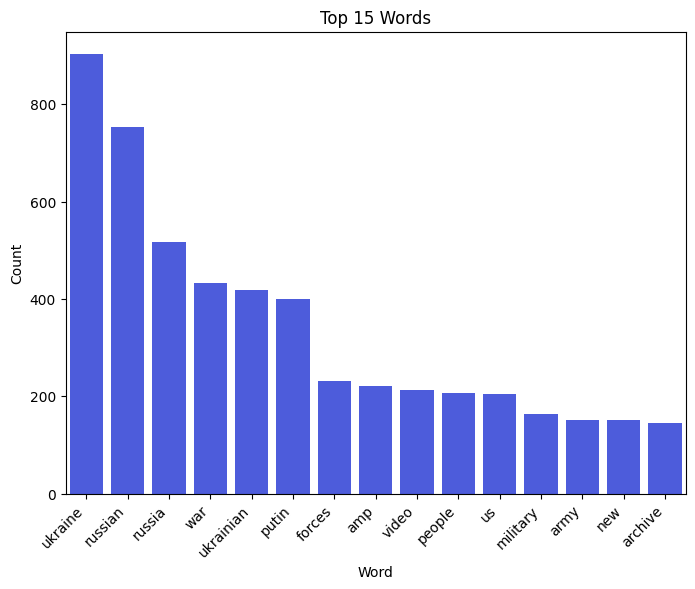

In [ ]:
# List containing all the words of all tweets
all_words = analytics_df['full_text'].apply(lambda x: preprocess_tweet(x,stemming=False, split=True)).explode().tolist()

# Create df with each word and its corresponding number of occurrences
counter_words = Counter(all_words)
counter_words_df = pd.DataFrame(list(counter_words.items()),columns=['word','count']).sort_values(by='count', ascending=False)

# Plot 30 most frequent words
plt.figure(figsize=(8, 6))
sns.barplot(x='word', y = 'count', data=counter_words_df.head(15), palette=['#3549F3'])
plt.xlabel('Word')
plt.ylabel('Count')
plt.title('Top 15 Words')
plt.xticks(rotation=45, ha='right')
plt.show()

###Word Cloud

In [ ]:
tweets = analytics_df['full_text'].apply(lambda x: preprocess_tweet(x, stemming=False, split=True))

# Initialize string that will contain all the words from all the tweets concatenated together, separated by spaces.
all_words = ''
stopwords = set(STOPWORDS)

for word in tweets:
    all_words += " ".join(word)+" "

wordcloud = WordCloud(width = 600, height = 600,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(all_words)

# Plot the WordCloud image
plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

###Average Sentence Length

In [ ]:
def count_words(tweet,stemming=False,split=True):
    """
    Count words in a tweet

    Argument:
    tweet which words we want to count

    Returns:
    number of words in that tweet
    """
    tweet_words = preprocess_tweet(tweet,stemming=False,split=True)
    return len(tweet_words)

In [ ]:
from nltk.corpus import stopwords

analytics_df['word_count'] = analytics_df['full_text'].apply(lambda x: count_words(x,stemming=False, split=True))
average = round(np.mean(analytics_df['word_count']))
print(f"The average sentence length is {average} words")

### Vocabulary size

To measure the vocabulary size we can simply get the number of distinct words across all tweets

In [ ]:
print("The vocabulary size is: ",len(set(all_words)))

### Most popular hashtags

In [ ]:
hashtag_count = Counter(analytics_df['hashtags'].explode().to_list())
counter_hashtag_df = pd.DataFrame(list(hashtag_count.items()),columns=['hashtag','count']).sort_values(by='count', ascending=False)

# Plot top 15 hashtags
plt.figure(figsize=(8, 6))
sns.barplot(x='hashtag', y = 'count', data=counter_hashtag_df.head(15), palette=['gold'])
plt.xlabel('Word')
plt.ylabel('Count')
plt.title('Top 15 Hashtags')
plt.xticks(rotation=45, ha='right')
plt.show()

### Ranking of tweets most retweeted

In [ ]:
analytics_df['username'] = json_df[['user.screen_name']]

In [ ]:
pd.set_option('max_colwidth', None)
print('TOP 10 MOST RETWEETED TWEETS: ')
display(analytics_df[['full_text','retweet_count']].sort_values(by='retweet_count',ascending=False).head(10))
pd.reset_option('max_colwidth')


### Sentiment analysis


- consider emoji?
- stemmed vs. unstemmed tokens

In [ ]:
nltk.download('vader_lexicon')

In [ ]:
all_tweets = analytics_df['full_text'].apply(lambda x: preprocess_tweet(x, stemming=False, split=False))

sia = SentimentIntensityAnalyzer()
neg_count = 0
pos_count = 0
neu_count = 0
for tweet in all_tweets:
  sentiment_scores = sia.polarity_scores(tweet)
  max_key = max(sentiment_scores, key=sentiment_scores.get)
  if max_key == 'neg':
    neg_count += 1
  if max_key == 'pos':
    pos_count += 1
  if max_key == 'neu':
    neu_count += 1

labels = ['Negative', 'Neutral', 'Positive']
counts = [neg_count, neu_count, pos_count]

plt.figure(figsize=(7, 7))

plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['red', 'lightgray', 'green'])
plt.title('Sentiment Analysis of Tweets')
plt.legend()
plt.show()

###Social Network Analysis

***Top mentioned users/entities***

In [ ]:
mentions = []
for tweet in all_tweets:
  mentions.append(re.findall(r'@(\w+)', tweet))
mentions_count = Counter([item for sublist in mentions for item in sublist])
counter_mentions_df = pd.DataFrame(list(mentions_count.items()),columns=['mention','count']).sort_values(by='count', ascending=False)

# Plot top 15 mentioned users
plt.figure(figsize=(8, 6))
sns.barplot(x='mention', y = 'count', data=counter_mentions_df.head(15), palette=['#76F2CB'])
plt.xlabel('User/entity')
plt.ylabel('Count')
plt.title('Top 15 Mentioned Users/Entities')
plt.xticks(rotation=45, ha='right')
plt.show()


***Twitter User Mention Network***

In [ ]:
# Create a directed graph
G = nx.DiGraph()

all_tweets = analytics_df['full_text'].apply(lambda x: preprocess_tweet(x, stemming=False, split=False))

for index, row in analytics_df[['full_text', 'username']].iterrows():
    username = row['username']
    tweet = row['full_text']

    # Extract mentions from the tweet
    mentions = re.findall(r'@(\w+)', tweet)

    # Add edges from the username to mentioned users
    for mentioned_user in mentions:
        G.add_edge(username, mentioned_user)

# Plot the network graph
plt.figure(figsize=(30,30))
nx.draw(G, with_labels=True,font_size=6, node_color='skyblue', edge_color='gray')
plt.title('Twitter User Mention Network')
plt.show()

In [ ]:

# Create a directed graph
G = nx.DiGraph()

for index, row in analytics_df[['full_text', 'username']].iterrows():
    username = row['username']
    tweet = row['full_text']

    # Extract mentions
    mentions = re.findall(r'@(\w+)', tweet)

    # Add edges from the username to mentioned users
    for mentioned_user in mentions:
        G.add_edge(username, mentioned_user)

# Calculate degree centrality
centrality = nx.degree_centrality(G)

# Identify the top 5 central nodes
top_nodes = sorted(centrality, key=centrality.get, reverse=True)[:5]

# Create a subgraph with only the top nodes and their neighbors
subgraph = G.subgraph(top_nodes + [neighbor for node in top_nodes for neighbor in G.neighbors(node)])


# Plot the network graph
plt.figure(figsize=(12, 12))
nx.draw(subgraph, with_labels=True, font_size=6, node_color='skyblue', edge_color='gray', arrowsize=10)
plt.title('Twitter User Mention Network (Top Central Nodes)')
plt.show()


***Most active users***




In [ ]:
# Create df with each word and its corresponding number of occurrences
counter_unames = Counter(analytics_df['username'])
counter_unames_df = pd.DataFrame(list(counter_unames.items()),columns=['username','count']).sort_values(by='count', ascending=False)
counter_unames_df

# Plot 15 most active users
plt.figure(figsize=(8, 6))
sns.barplot(x='username', y = 'count', data=counter_unames_df.head(15), palette=['#E6E6FA'])
plt.xlabel('Username')
plt.ylabel('Count')
plt.title('Top 15 Most Active Users')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
top_usernames = counter_unames_df.head(15)['username']
analytics_df.loc[analytics_df['username'].isin(top_usernames)].drop_duplicates(subset='username')[['full_text','username']].head(15)

***Users of the most retweeted and liked tweets***

In [ ]:
retweet_counts_by_user = analytics_df.groupby('username')['retweet_count'].sum()

# Get the top usernames with the highest total retweets
top_retweet_users = retweet_counts_by_user.nlargest(5)

# Create the bar plot
plt.figure(figsize=(4, 4))
ax = sns.barplot(x=top_retweet_users.index, y=top_retweet_users.values, color='#F15083')
ax.set(xlabel='Usernames', ylabel='Total Retweets')
plt.title('Top Users by Total Retweets')
plt.xticks(rotation=45, ha='right')

plt.show()

In [ ]:
analytics_df[['full_text','favorite_count']].sort_values(by='favorite_count',ascending=False).head(10)
fav_counts_by_user = analytics_df.groupby('username')['favorite_count'].sum()

# Get the top usernames with the highest total retweets
top_fav_users = fav_counts_by_user.nlargest(5)

# Create the bar plot
plt.figure(figsize=(4, 4))
ax = sns.barplot(x=top_fav_users.index, y=top_fav_users.values, color='#F15083')
ax.set(xlabel='Usernames', ylabel='Total Favourites')
plt.title('Top Users by Total Favourites')
plt.xticks(rotation=45, ha='right')

plt.show()

###Temporal Distribution of Tweets on Russia-Ukraine War

In [ ]:
def get_hour(date):
  d = datetime.strptime(date, "%a %b %d %H:%M:%S %z %Y")
  return d.hour

analytics_df['hour_created'] = analytics_df['created_at'].apply(lambda x: get_hour(x))

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(analytics_df['hour_created'], bins=20,kde=False, color='#539726')
plt.xticks(range(25))
plt.xlabel('Hour Created')
plt.ylabel('Count')
plt.title('Hourly Distribution of Tweets on Russia-Ukraine War')
plt.show()

### analytics df header and info

In [ ]:
pd.set_option('max_colwidth', None)
analytics_df.head(3)

In [ ]:
analytics_df.info()

# **Part 2: Indexing and Evaluation**

## Build Inverted Index

To create the index we will perform the following steps:


*   Loop over all tweets of the collection in the dataframe final_df.
*   Concatenate of all the tweets.
*   Lowercase all words.
*   Get tokens (transform the string into a list of terms)
*   Remove stop words
*   Stem each token


In [ ]:
def create_index(lines):
    """
    Implement the inverted index

    Argument:
    lines -- collection of tweets

    Returns:
    index - the inverted index (implemented through a Python dictionary) containing terms as keys and the corresponding
    list of documents where these keys appears in (and the positions) as values.
    """
    inv_index = defaultdict(list)

    for index, tweet in final_df.iterrows():

        processed_hashtags = []
        for x in tweet['hashtags']: # Preprocess the hashtags as text to include them in the dic
          words = re.findall(r'[A-Z][a-z]*', x)
          for i in words:
            processed_hashtags.append(preprocess_tweet(i, stemming=False, split=False))

        terms = np.union1d(tweet['preprocessed_text'], processed_hashtags)
        doc_id = index
        current_page_index = {}

        for position, term in enumerate(terms):
            try:
                # If the term is already in the index for the current page (current_page_index) and append the position to the list
                current_page_index[term][1].append(position)
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                current_page_index[term]=[doc_id, array('I',[position])]
        # Merge the current page index with the main index
        for term_page, posting_page in current_page_index.items():
            inv_index[term_page].append(posting_page)

    return inv_index

In [ ]:
import time
start_time = time.time()
inverted_index = create_index(final_df)
print("Total time to create the index: {} seconds".format(np.round(time.time() - start_time, 2)))

Total time to create the index: 8.14 seconds


## Propose test queries

Five queries that we will use to evaluate our search
engine:

* "Ukrainan regions annexated"
* "Situation on the Lyman front"
* "Nord Stream gas pipeline"
* "United States (US) President Biden"
* "Zelensky NATO"













## Rank your results

Here we implemented the TF-IDF (Term Frequency — Inverse Document Frequency) mechanism and use it to obtain a list of ordered results.

TF-IDF is a weighting scheme that assigns each term in a document a weight based on its term frequency (FT) and the inverse document frequency (IDF). The higher the scores, more important the term is.

In [ ]:
def create_index_tfidf(lines, num_documents):
    """
    Implement the inverted index and compute tf, df and idf

    Argument:
    lines -- collection of Wikipedia articles
    num_documents -- total number of documents

    Returns:
    index - the inverted index (implemented through a Python dictionary) containing terms as keys and the corresponding
    list of document these keys appears in (and the positions) as values.
    tf - normalized term frequency for each term in each document
    df - number of documents each term appear in
    idf - inverse document frequency of each term
    """

    inv_index = defaultdict(list)
    tf = defaultdict(list)
    df = defaultdict(int)
    idf = defaultdict(float)

    for index, tweet in final_df.iterrows():

        processed_hashtags = []
        for x in tweet['hashtags']: # Preprocess the hashtags as text to include them in the dic
          words = re.findall(r'[A-Z][a-z]*', x)
          for i in words:
            processed_hashtags.append(preprocess_tweet(i, stemming=False, split=False))
        terms = np.union1d(tweet['preprocessed_text'], processed_hashtags)
        doc_id = index
        current_page_index = {}

        for position, term in enumerate(terms):
            try:
                # if the term is already in the dict append the position to the corresponding list
                current_page_index[term][1].append(position)
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                current_page_index[term]=[doc_id, array('I',[position])]

        norm = 0
        for term, posting in current_page_index.items():
            # posting contains the list of positions for current term in current document.
            # posting ==> [current_doc, [list of positions]]
            norm += len(posting[1]) ** 2
        norm = math.sqrt(norm)

        # Calculate the tf and df weights
        for term, posting in current_page_index.items():
            # Append the tf for current term
            tf[term].append(np.round(len(posting[1])/norm,4))

            # Increment the document frequency of current term (number of documents containing the current term)
            df[term] += 1 #

        # Merge the current page index with the main index
        for term_page, posting_page in current_page_index.items():
            inv_index[term_page].append(posting_page)

        # Compute idf
        for term in df:
            idf[term] = np.round(np.log(float(num_documents/df[term])), 4)

    return inv_index, tf, df, idf


In [ ]:
import time
start_time = time.time()
num_documents = len(final_df)
inv_index, tf, df, idf = create_index_tfidf(final_df, num_documents)
print("Total time to create the index: {} seconds" .format(np.round(time.time() - start_time, 2)))

Total time to create the index: 248.02 seconds


In [ ]:
def rank_documents(terms, docs, index, idf, tf):
    """
    Perform the ranking of the results of a search based on the tf-idf weights

    Argument:
    terms -- list of query terms
    docs -- list of documents, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies
    title_index -- mapping between page id and page title

    Returns:
    Print the list of ranked documents
    """

    # We're only interested on the element of the docVector corresponding to the query terms the remaining elements would became 0 when multiplied to the query_vector
    doc_vectors = defaultdict(lambda: [0] * len(terms))
    query_vector = [0] * len(terms)

    # Compute the norm for the query tf
    query_terms_count = collections.Counter(terms)  # get the frequency of each term in the query.

    query_norm = la.norm(list(query_terms_count.values()))

    # Filter docs containing ALL terms in the query
    filtered_docs = []

    for termIndex, term in enumerate(terms):  #termIndex is the index of the term in the query
        if term not in index:
            continue

        # Compute vector of the query
        query_vector[termIndex]=query_terms_count[term] * idf[term]

        # Generate doc_vectors for matching docs
        for doc_index, (doc, postings) in enumerate(index[term]):
            #tf[term][0] will contain the tf of the term "term" in the doc 26
            if doc in docs:
                doc_vectors[doc][termIndex] = tf[term][doc_index] * idf[term]


    # Normalize query vector and doc vectors
    query_vector /= la.norm(query_vector)
    for doc in docs:
      if doc in doc_vectors:
          doc_vector = doc_vectors[doc]

          norm = la.norm(doc_vector)

          if norm > 0:
              doc_vectors[doc] = [x / norm for x in doc_vector]

    # Calculate the score of each doc
    # compute the cosine similarity between queryVector and each docVector, which becomes dot product since vectors are normalized
    doc_scores = [[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items()]
    doc_scores.sort(reverse=True)

    result_docs = [x[1] for x in doc_scores]

    if len(result_docs) == 0:
        print("No results found, try again")
        query = input()
        docs = search_tf_idf(query, index)

    return result_docs, doc_scores

In [ ]:
def search_tf_idf(query, index):
    """
    output is the list of documents that contain ALL of the query terms
    """

    query = preprocess_tweet(query,stemming=True, split=True)
    # initialize docs with the documents contining the first term
    first_term = query[0]
    try:
        docs = set(posting[0] for posting in index[first_term])
    except KeyError:
        # if the first term is not in index, return empty lists
        return []
    # iterate over the remaining terms and take intersection with docs, having then only the docs that contain all the terms in the query
    for term in query[1:]:
        try:
            # store in term_docs the ids of the docs that contain term
            term_docs = {posting[0] for posting in index[term]}

            # take the intersection of docs and term_docs
            docs &= term_docs
        except KeyError:
            # term is not in index
            pass

    docs = list(docs)
    ranked_docs, doc_scores = rank_documents(query, docs, index, idf, tf)
    return ranked_docs, doc_scores

In [ ]:
print("Insert your query:\n")
query = input()
ranked_docs, doc_scores = search_tf_idf(query, inv_index)
top = 10

final_df['text (shortened)'] = final_df['full_text'].apply(lambda x: x[:100]+ '...' )
final_df['hashtags (shortened)'] = final_df['hashtags'].apply(lambda x: x[:5])
print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs)))
for d_id in ranked_docs[:top]:
    print(final_df.loc[d_id, ['created_at', 'id', 'text (shortened)','favorite_count', 'retweet_count', 'hashtags (shortened)', 'tweet_url']])
    print("---------------------------------------------")
final_df = final_df.drop(columns=['hashtags (shortened)','text (shortened)'])

Insert your query:

tank in kharkiv
docs:  ['doc_2701', 'doc_3233', 'doc_2234', 'doc_399', 'doc_2570', 'doc_1399', 'doc_1730', 'doc_2422', 'doc_1928', 'doc_1712', 'doc_2586', 'doc_1492', 'doc_257', 'doc_2170', 'doc_3709', 'doc_2541', 'doc_3783', 'doc_3478', 'doc_3623', 'doc_2425', 'doc_747', 'doc_3546', 'doc_2410', 'doc_3556', 'doc_1970', 'doc_592']

Top 10 results out of 26 for the searched query:

created_at                                                                                        Fri Sep 30 12:17:04 +0000 2022
id                                                                                                           1575822033253867521
text (shortened)        #Russia #Ukraine #Europe \nWhy The West Hesitant To Supply Modern Tanks Like M1 Abrams\Leopard To Ukr...
favorite_count                                                                                                                 0
retweet_count                                                                    

## Evaluation

#### Using subset of the dataset (Evaluation_gt file)

In [ ]:
# import ground truth files for each query
evaluation = pd.read_csv("/content/drive/Shareddrives/IRWA/part2/Evaluation_gt.csv")
evaluation.head()

,doc,query_id,label
0,doc_2052,Q3,1
1,doc_164,Q3,1
2,doc_411,Q3,1
3,doc_1805,Q3,1
4,doc_3442,Q3,1


In [ ]:
evaluation['predicted_relevance'] = 0
evaluation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   doc                  60 non-null     object
 1   query_id             60 non-null     object
 2   label                60 non-null     int64 
 3   predicted_relevance  60 non-null     int64 
dtypes: int64(2), object(2)
memory usage: 2.0+ KB


In [ ]:
evaluation_id = evaluation['doc'].to_frame()

In [ ]:
# Define the queries
q1 = 'tank in Kharkiv'
q2 = 'Nord stream pipeline'
q3 = 'annexation territories by Russia'

def update_predicted_relevance(evaluation, queries, inv_index):
    relevant_scores = {}

    # Iterate through the queries and update relevant_scores dictionary
    for i, query in enumerate(queries):
        ranked_docs, doc_scores = search_tf_idf(query, inv_index)
        relevant_scores[f"Q{i+1}"] = {d_id: predicted_relevance for predicted_relevance, d_id in doc_scores}

    # Iterate through the search results and update predicted_relevance column
    for i, (query_id, d_id) in enumerate(zip(evaluation["query_id"], evaluation["doc"])):
        if query_id in relevant_scores and d_id in relevant_scores[query_id]:
            evaluation.at[i, "predicted_relevance"] = relevant_scores[query_id][d_id]
        else:
            # Keep the existing value in the "predicted_relevance" column
            pass

# Example usage
queries = [q1, q2, q3]
update_predicted_relevance(evaluation, queries, inv_index)

In [ ]:
ordered_eval = evaluation.sort_values(by='predicted_relevance', ascending=False)
ordered_eval.reset_index(drop=True, inplace=True)

In [ ]:
# Create separate DataFrames for each query
evaluation_q1 = evaluation[(evaluation["query_id"] == 'Q1')].copy()
evaluation_q2 = evaluation[(evaluation["query_id"] == 'Q2')].copy()
evaluation_q3 = evaluation[(evaluation["query_id"] == 'Q3')].copy()

In [ ]:
# Print the resulting DataFrames
print("Evaluation Q1:")
display(evaluation_q1)
print("\nEvaluation Q2:")
display(evaluation_q2)
print("\nEvaluation Q3:")
display(evaluation_q3)

Evaluation Q1:


,doc,query_id,label,predicted_relevance
40,doc_2234,Q1,1,1.0
41,doc_2656,Q1,1,0.0
42,doc_3709,Q1,1,1.0
43,doc_592,Q1,1,1.0
44,doc_3556,Q1,1,1.0
45,doc_2586,Q1,1,1.0
46,doc_2701,Q1,1,1.0
47,doc_3478,Q1,1,1.0
48,doc_2956,Q1,1,0.0
49,doc_3552,Q1,1,0.0



Evaluation Q2:


,doc,query_id,label,predicted_relevance
20,doc_1452,Q2,1,1.0
21,doc_2908,Q2,1,1.0
22,doc_618,Q2,1,1.0
23,doc_2677,Q2,1,1.0
24,doc_489,Q2,1,1.0
25,doc_110,Q2,1,1.0
26,doc_3439,Q2,1,0.0
27,doc_3137,Q2,1,1.0
28,doc_3913,Q2,1,1.0
29,doc_2696,Q2,1,1.0



Evaluation Q3:


,doc,query_id,label,predicted_relevance
0,doc_2052,Q3,1,1.0
1,doc_164,Q3,1,0.0
2,doc_411,Q3,1,1.0
3,doc_1805,Q3,1,1.0
4,doc_3442,Q3,1,1.0
5,doc_2657,Q3,1,1.0
6,doc_1534,Q3,1,1.0
7,doc_383,Q3,1,1.0
8,doc_1618,Q3,1,1.0
9,doc_63,Q3,1,1.0


In [ ]:
# Iterate through doc_id in evaluation_q1 and match with final_df
for doc_id in evaluation_q1["doc"]:
    if doc_id in final_df.index:
        matching_text = final_df.loc[doc_id, "full_text"]
        print("----------------------------------------------------------------")
        print("Matching text for doc_id", doc_id, ":", matching_text)
    else:
        print("No matching text found for doc_id", doc_id)

----------------------------------------------------------------
Matching text for doc_id doc_2234 : Destroyed Ukrainian tank in the Kharkiv region.

#Ukraine #Ukrainewar #UkraineRussiaWar #Kharkiv https://t.co/xt4JVrWchP
----------------------------------------------------------------
Matching text for doc_id doc_2656 : Ukrainian MT-LB along with military personnel was blown up by an anti-tank mine in the Kharkiv direction.

#Ukraine #Ukrainewar #UkraineRussiaWar #MTLB #Kharkiv https://t.co/1oBT6wXfPl
----------------------------------------------------------------
Matching text for doc_id doc_3709 : Soldiers of the Ukrainian army seizing a Russian tank in the #Kharkiv region 

#Ukraine-#UkraineRussianWar -#UkraineWar -#UkraineRussiaWar-#Russian https://t.co/7zqjb8cYCE
----------------------------------------------------------------
Matching text for doc_id doc_592 : 👏Footage of a Russian tank being knocked out by Ukrainian forces in Ol'hivka, Kharkiv Oblast.
#Russian #Russia #Ukraine

In [ ]:
# Iterate through user_id in evaluation_q2 and match with final_df
for doc_id in evaluation_q2["doc"]:
    if doc_id in final_df.index:
        matching_text = final_df.loc[doc_id, "full_text"]
        print("----------------------------------------------------------------")
        print("Matching text for doc_id", doc_id, ":", matching_text)
    else:
        print("No matching text found for doc_id", doc_id)

----------------------------------------------------------------
Matching text for doc_id doc_1452 : #UkraineWar #Ukraine #Russia #ukrainerussiawar #Putin #SanktionengegendieUSA #MAGA #俄罗斯 #乌克兰 #中國

Moscow insists on a probe into the circumstances of "unprecedented attacks" on Russian Nord Stream and Nord Stream 2 gas pipeline,
----------------------------------------------------------------
Matching text for doc_id doc_2908 : ❗️ "Sabotage" that caused destruction on the strings of the Nord Stream and Nord Stream 2 gas pipelines could lead to escalation or even war - former US President Donald Trump
#UkraineRussiaWar
----------------------------------------------------------------
Matching text for doc_id doc_618 : ❗🇷🇺 The Anglo-Saxon's blew up the Nord Stream pipelines - Putin.

#Russia #RussiaInvadedUkraine #Ukraine #UkraineRussiaWar
#NordStream2
----------------------------------------------------------------
Matching text for doc_id doc_2677 : Opinion | Russia is the most likely cu

In [ ]:
# Iterate through user_id in evaluation_q3 and match with final_df
for doc_id in evaluation_q3["doc"]:
    if doc_id in final_df.index:
        print("----------------------------------------------------------------")
        matching_text = final_df.loc[doc_id, "full_text"]
        print("Matching text for doc_id", doc_id, ":", matching_text)
    else:
        print("No matching text found for doc_id", doc_id)

----------------------------------------------------------------
Matching text for doc_id doc_2052 : Russia is set to claim annexation of occupied territories in Ukraine. #UkraineRussiaWar #UkraineWar #annexation #Russia #Ukraine #NATO
https://t.co/DrChSVClJ4
----------------------------------------------------------------
Matching text for doc_id doc_164 : It’s shambolic when I see more tweets about the financial situation than I do about Russia’s annexation of 15pc of Ukraine. #UkraineRussiaWar #annexation
----------------------------------------------------------------
Matching text for doc_id doc_411 : Zelensky calls Russia's illegal annexation of Ukrainian territories a "farce"  https://t.co/pSdDrUR6wB #Ukraine  #UkraineRussiaWar #UkraineUnderAttack #UkraineWarNews
----------------------------------------------------------------
Matching text for doc_id doc_1805 : The threat comes amid the upcoming annexation of four formally-Ukrainian territories this week.

#UkraineRussiaWar | #

#### Expert judges

In [ ]:
# Define the queries
q1 = "Ukrainan regions annexated"
q2 = "Situation on the Lyman front"
q3 = "Nord Stream gas pipeline"
q4 = "United States (US) President Biden"
q5 = "Zelensky NATO"

In [ ]:
columns_table=["doc_id","query_id", "predicted_relevance"]
queries = [q1, q2, q3, q4, q5]

q1_eval_df = pd.DataFrame([],columns=columns_table)
q2_eval_df = pd.DataFrame([],columns=columns_table)
q3_eval_df = pd.DataFrame([],columns=columns_table)
q4_eval_df = pd.DataFrame([],columns=columns_table)
q5_eval_df = pd.DataFrame([],columns=columns_table)

relevant_scores={}
for i, query in enumerate(queries):
  ranked_docs, doc_scores = search_tf_idf(query, inv_index)
  relevant_scores[f"Q{i+1}"] = {d_id: predicted_relevance for predicted_relevance, d_id in doc_scores}
  if (i == 0):
    for x in range(len(doc_scores)):
      q1_eval_df = pd.DataFrame(np.insert(q1_eval_df.values, x, values=[doc_scores[x][1], 1, doc_scores[x][0]], axis=0))
  elif (i == 1):
    for x in range(len(doc_scores)):
      q2_eval_df = pd.DataFrame(np.insert(q2_eval_df.values, x, values=[doc_scores[x][1], 2, doc_scores[x][0]], axis=0))
  elif (i == 2):
    for x in range(len(doc_scores)):
      q3_eval_df = pd.DataFrame(np.insert(q3_eval_df.values, x, values=[doc_scores[x][1], 3, doc_scores[x][0]], axis=0))
  elif (i == 3):
    for x in range(len(doc_scores)):
      q4_eval_df = pd.DataFrame(np.insert(q4_eval_df.values, x, values=[doc_scores[x][1], 4, doc_scores[x][0]], axis=0))
  elif (i == 4):
    for x in range(len(doc_scores)):
      q5_eval_df = pd.DataFrame(np.insert(q5_eval_df.values, x, values=[doc_scores[x][1], 5, doc_scores[x][0]], axis=0))

q1_eval_df.columns=columns_table
q2_eval_df.columns=columns_table
q3_eval_df.columns=columns_table
q4_eval_df.columns=columns_table
q5_eval_df.columns=columns_table


In [ ]:
matching_texts = []
for doc_id in q1_eval_df["doc_id"]:
  if doc_id in final_df.index:
    matching_text = final_df.loc[doc_id, "full_text"]
    matching_texts.append(matching_text)
q1_eval_df["full_text"] = matching_texts

matching_texts = []
for doc_id in q2_eval_df["doc_id"]:
  if doc_id in final_df.index:
    matching_text = final_df.loc[doc_id, "full_text"]
    matching_texts.append(matching_text)
q2_eval_df["full_text"] = matching_texts

matching_texts = []
for doc_id in q3_eval_df["doc_id"]:
  if doc_id in final_df.index:
    matching_text = final_df.loc[doc_id, "full_text"]
    matching_texts.append(matching_text)
q3_eval_df["full_text"] = matching_texts

matching_texts = []
for doc_id in q4_eval_df["doc_id"]:
  if doc_id in final_df.index:
    matching_text = final_df.loc[doc_id, "full_text"]
    matching_texts.append(matching_text)
q4_eval_df["full_text"] = matching_texts

matching_texts = []
for doc_id in q5_eval_df["doc_id"]:
  if doc_id in final_df.index:
    matching_text = final_df.loc[doc_id, "full_text"]
    matching_texts.append(matching_text)
q5_eval_df["full_text"] = matching_texts


In [ ]:
# 10 docs related to query 1 (under our judgement)
q1_related = q1_eval_df[q1_eval_df.predicted_relevance > 0.8].reset_index(drop=True).head(10)
q1_related['our_ground_truth'] = [1,1,1,1,1,1,1,1,1,1]

# 10 docs not related to query 1 (under our judgement)
q1_not_related = q1_eval_df[q1_eval_df.predicted_relevance < 0.7].reset_index(drop=True).tail(10)
q1_not_related['our_ground_truth']= [0,0,0,0,0,0,0,0,0,0]

# 10 docs related to query  (under our judgement)
additional_rows = q2_eval_df[q2_eval_df.doc_id.isin(['doc_707', 'doc_3642', 'doc_3534'])]
q2_related = pd.concat([q2_eval_df[q2_eval_df.predicted_relevance > 0.8],additional_rows]).reset_index(drop=True).head(10)
q2_related['our_ground_truth'] = [1,1,1,1,1,1,1,1,1,1]

# 10 docs not related to query 2 (under our judgement)
q2_not_related = q2_eval_df[q2_eval_df['doc_id'].isin(['doc_1022','doc_1063','doc_1101','doc_1286','doc_1768','doc_3175','doc_2445','doc_1133','doc_1151','doc_1825'])].reset_index(drop=True)
q2_not_related['our_ground_truth']= [0,0,0,0,0,0,0,0,0,0]

# 10 docs related to query 3 (under our judgement)
q3_related = q3_eval_df[q3_eval_df.predicted_relevance > 0.8].reset_index(drop=True).head(10)
q3_related['our_ground_truth'] = [1,1,1,1,1,1,1,1,1,1]

# 10 docs not related to query 3 (under our judgement)
q3_not_related = q3_eval_df[q3_eval_df['doc_id'].isin(['doc_3430','doc_3340','doc_3263','doc_2983','doc_2935','doc_2887','doc_2147','doc_2047','doc_1934','doc_1760'])].reset_index(drop=True)
q3_not_related['our_ground_truth']= [0,0,0,0,0,0,0,0,0,0]

# 10 docs related to query 4 (under our judgement)
q4_related = q4_eval_df[q4_eval_df['doc_id'].isin(['doc_3692','doc_156','doc_418','doc_143','doc_3487','doc_2447', 'doc_3383', 'doc_1771','doc_729','doc_3920'])].reset_index(drop=True)
q4_related['our_ground_truth']= [1,1,1,1,1,1,1,1,1,1]

# 10 docs not related to query 4 (under our judgement)
q4_not_related = q4_eval_df.tail(10).reset_index(drop=True)
q4_not_related['our_ground_truth']= [0,0,0,0,0,0,0,0,0,0]

# 10 docs related to query 5 (under our judgement)
q5_related = q5_eval_df.head(10).reset_index(drop=True)
q5_related['our_ground_truth']= [1,1,1,1,1,1,1,1,1,1]

# 10 docs not related to query 5 (under our judgement)
q5_not_related = q5_eval_df.tail(10).reset_index(drop=True)
q5_not_related['our_ground_truth']= [0,0,0,0,0,0,0,0,0,0]

In [ ]:
query1_eval = pd.concat([q1_related,q1_not_related, q2_related, q3_related, q4_related, q5_related ]).reset_index(drop=True)
query1_eval

,doc_id,query_id,predicted_relevance,full_text,our_ground_truth
0,doc_934,1,1.0,Russian strike kills 25 as Kremlin to annex Ukraine regions \n#Russian #UkraineRussiaWar \nhttps://t.co/bmuiM5TJGd,1
1,doc_89,1,1.0,"A few of us got together and signed some documents that legally annex the #Volga region of #Russia. I asked 3 people there who told me to get lost, so we clearly have 98% support. Does anyone want to join the new administration? Our vet seems keen. #Ukraine #UkraineRussiaWar",1
2,doc_88,1,1.0,"The EU, the US, GB, Japan, in fact all of the countries sanctioning Russia because of their war in Ukraine, should sign into law that those sanctions will remain in place until all forcefully annexed regions of Ukraine return to Ukraine. #Ukraine #UkraineRussiaWar #Putin",1
3,doc_868,1,1.0,"One more time. #Russia announces annexation of regions, none of which is fully controlled by #Putin. What “will of people” is someone speaking? Can you imagine you, living dozens and hundreds km from occupied territory, being said, you are part of Russia now? #UkraineRussiaWar",1
4,doc_809,1,1.0,#UkraineRussiaWar | Russia formally annexes four occupied Ukrainian regions,1
5,doc_704,1,1.0,#JustIn | Russian President Vladimir Putin begins speech at Kremlin ceremony to annex Ukraine regions | reported by news agency AFP\n\n#UkraineRussiaWar,1
6,doc_668,1,1.0,Putin announces Russia will annex four regions of Ukraine\n#PutinIsaWarCriminal #UkraineRussiaWar \nhttps://t.co/ThlvOjRest,1
7,doc_581,1,1.0,"The 🇷🇺president #Putin has just signed the decree to annex the occupied Ukrainian regions of #Kherson, #Zaporizhzhia, #Donetsk and #Luhansk. What will be next? The Ukrainian Army will deoccupy all Ukrainian territories.\n#Ukraine #UkraineWar #UkraineRussiaWar #Russia #Russians https://t.co/t4yHRoDuxU",1
8,doc_531,1,1.0,UKRAINE WAR LATEST | NIKKEI ASIA BLOG\n\n-- EU chief calls Russia's annexation illegal\n-- Putin announces annexation of four Ukrainian regions\n\n#Ukraine #UkraineRussiaWar #Russia #RussiaUkraineWar #Putin\nhttps://t.co/0TtSQeoi5l,1
9,doc_465,1,1.0,Online retailer Sima-Land staged another show of support and loyalty to Putin over the declared annexation of 4 partially Russian-occupied regions of #Ukraine. \n\n#UkraineRussiaWar \n#UkraineWar https://t.co/lakd9TtvQS,1


In [ ]:
query2_eval = pd.concat([q2_related,q2_not_related, q1_related, q3_related, q4_related, q5_related ]).reset_index(drop=True)
query2_eval

In [ ]:
query3_eval = pd.concat([q3_related,q3_not_related, q1_related, q2_related, q4_related, q5_related ]).reset_index(drop=True)
query3_eval

In [ ]:
query4_eval = pd.concat([q4_related,q4_not_related, q1_related, q2_related, q3_related, q5_related ]).reset_index(drop=True)
query4_eval

In [ ]:
query5_eval = pd.concat([q5_related,q5_not_related, q1_related, q2_related, q3_related, q4_related ]).reset_index(drop=True)
query5_eval

### Evaluation techinques

#### Precision@K (P@K)

Precision at K (P@K) measures the number of relevant results among the top K documents.

In [ ]:
def precision_at_k(doc_score, y_score, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    precision @k : float

    """
    order = np.argsort(y_score)[::-1]
    doc_score = np.take(doc_score, order[:k])
    relevant = sum(doc_score == 1)
    return float(relevant) / k

In [ ]:
# Precision at P@10 for query 1: "Ukrainan regions annexated"
current_query = 1
current_query_res = query1_eval[query1_eval["query_id"] == current_query]
pres_q1 = precision_at_k(current_query_res['our_ground_truth'],current_query_res['predicted_relevance'],10)
print("The precision at 10 (P@10) of query 1 is: ", pres_q1)

# Precision at P@10 for query 2: "Situation on the Lyman front"
current_query = 2
current_query_res = query2_eval[query2_eval["query_id"] == current_query]
pres_q2 = precision_at_k(current_query_res['our_ground_truth'],current_query_res['predicted_relevance'],10)
print("The precision at 10 (P@10) of query 2 is: ", pres_q2)

# Precision at P@10 for query 3: "United States role in Russian-Ukraine War"
current_query = 3
current_query_res = query3_eval[query3_eval["query_id"] == current_query]
pres_q3 = precision_at_k(current_query_res['our_ground_truth'],current_query_res['predicted_relevance'],10)
print("The precision at 10 (P@10) of query 3 is: ", pres_q3)

# Precision at P@10 for query 4: "Nord Stream gas pipeline"
current_query = 4
current_query_res = query4_eval[query4_eval["query_id"] == current_query]
pres_q4 = precision_at_k(current_query_res['our_ground_truth'],current_query_res['predicted_relevance'],10)
print("The precision at 10 (P@10) of query 4 is: ", pres_q4)

# Precision at P@10 for query 5: "NATO Allies support Ukraine"
current_query = 5
current_query_res = query5_eval[query5_eval["query_id"] == current_query]
pres_q5 = precision_at_k(current_query_res['our_ground_truth'],current_query_res['predicted_relevance'],10)
print("The precision at 10 (P@10) of query 5 is: ", pres_q5)

#### Average Precision@K - AP@K

𝐴𝑃@𝐾  gives a better intuition of the model ability to sort the results for a specific query. It tells how much the relevant documents are concentrated in the highest ranked predictions.

In [ ]:
def avg_precision_at_k(doc_score, y_score, k=20):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    average precision @k : float
    """
    gtp = np.sum(doc_score == 1)
    order = np.argsort(y_score)[::-1]
    doc_score = np.take(doc_score, order[:k])
    ## if all documents are not relevant
    if gtp == 0:
        return 0
    n_relevant_at_i = 0
    prec_at_i = 0
    for i in range(len(doc_score)):
        if doc_score[i] == 1:
            n_relevant_at_i += 1
            prec_at_i += n_relevant_at_i / (i + 1)
    return prec_at_i / gtp

In [ ]:
# Precision at AP@10 for query 1: "Ukrainan regions annexated"
current_query = 1
current_query_res = query1_eval[query1_eval["query_id"] == current_query]
pres_q1 = avg_precision_at_k(np.array(current_query_res['our_ground_truth']),np.array(current_query_res['predicted_relevance']),10)
print("AP@10 of query 1 is: ", pres_q1)

# Precision at AP@10 for query 2: "Situation on the Lyman front"
current_query = 2
current_query_res = query1_eval[query2_eval["query_id"] == current_query]
pres_q2 = precision_at_k(np.array(current_query_res['our_ground_truth']),np.array(current_query_res['predicted_relevance']),10)
print("AP@10 of query 2 is: ", pres_q2)

# Precision at AP@10 for query 3: "United States role in Russian-Ukraine War"
current_query = 3
current_query_res = query3_eval[query3_eval["query_id"] == current_query]
pres_q3 = precision_at_k(np.array(current_query_res['our_ground_truth']),np.array(current_query_res['predicted_relevance']),10)
print("AP@10 of query 3 is: ", pres_q3)

# Precision at AP@10 for query 4: "Nord Stream gas pipeline"
pres_q4 = precision_at_k(np.array(query4_eval['our_ground_truth']),np.array(query4_eval['predicted_relevance']),10)
print("AP@10 of query 4 is: ", pres_q4)

# Precision at AP@10 for query 5: "NATO Allies support Ukraine"
pres_q5 = precision_at_k(np.array(query5_eval['our_ground_truth']),np.array(query5_eval['predicted_relevance']),10)
print("AP@10 of query 5 is: ", pres_q5)

#### Mean Average Precision (mAP)


The Mean Average Precision (mAP) is simply the **mean** of all the queries AP. This metric is not computed for a single query as previous metrics, but it takes into account all the queries.


In [ ]:
def map_at_k(search_res, k=10):
    """
    Parameters
    ----------
    search_res: search results dataset containing:
        query_id: query id.
        doc_id: document id.
        predicted_relevance: relevance predicted through LightGBM.
        doc_score: actual score of the document for the query (ground truth).

    Returns
    -------
    mean average precision @ k : float
    """
    avp = []
    for q in search_res["query_id"].unique():  # loop over all query id
        curr_data = search_res[search_res["query_id"] == q]  # select data for current query
        avp.append(avg_precision_at_k(np.array(curr_data["our_ground_truth"]),
                   np.array(curr_data["predicted_relevance"]), k))  #append average precision for current query
    return np.sum(avp) / len(avp)

In [ ]:
pres_q1 = map_at_k(query1_eval,60)
print("mAP of query 1 is: ", pres_q1)

pres_q2 = map_at_k(query2_eval,60)
print("mAP of query 2 is: ", pres_q2)

pres_q3 = map_at_k(query3_eval,60)
print("mAP of query 3 is: ", pres_q3)

pres_q4 = map_at_k(query4_eval,60)
print("mAP of query 4 is: ", pres_q4)

pres_q5 = map_at_k(query5_eval,60)
print("mAP of query 5 is: ", pres_q5)

#### Mean Reciprocal Rank (MRR)


The Mean Reciprocal Rank (MRR) can be defined as the mean of the RR for all queries:

In [ ]:
def rr_at_k(doc_score, y_score, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    Reciprocal Rank for qurrent query
    """

    order = np.argsort(y_score)[::-1]  # get the list of indexes of the predicted score sorted in descending order.
    doc_score = np.take(doc_score, order[
                             :k])  # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k.
    if np.sum(doc_score) == 0:  # if there are not relevant doument return 0
        return 0
    return 1 / (np.argmax(doc_score == 1) + 1)  # hint: to get the position of the first relevant document use "np.argmax"


In [ ]:
pres_q1 = rr_at_k(query1_eval['our_ground_truth'],query1_eval['predicted_relevance'],60)
print("MRR of query 1 is: ", pres_q1)

pres_q2 = rr_at_k(query2_eval['our_ground_truth'],query2_eval['predicted_relevance'],60)
print("MRR of query 1 is: ", pres_q2)

pres_q1 = rr_at_k(query3_eval['our_ground_truth'],query3_eval['predicted_relevance'],60)
print("MRR of query 1 is: ", pres_q3)

pres_q1 = rr_at_k(query4_eval['our_ground_truth'],query4_eval['predicted_relevance'],60)
print("MRR of query 1 is: ", pres_q4)

pres_q1 = rr_at_k(query5_eval['our_ground_truth'],query5_eval['predicted_relevance'],60)
print("MRR of query 1 is: ", pres_q5)



#### Normalized Discounted Cumulative Gain (NDCG)


In [ ]:
def dcg_at_k(doc_score, y_score, k=10):
    order = np.argsort(y_score)[::-1]  # get the list of indexes of the predicted score sorted in descending order.
    doc_score = np.take(doc_score, order[:k])  # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k.
    gain = 2 ** doc_score - 1  # Compute gain (use formula 7 above)
    discounts = np.log2(np.arange(len(doc_score)) + 2)  # Compute denominator
    return np.sum(gain / discounts)  #return dcg@k


def ndcg_at_k(doc_score, y_score, k=10):
    dcg_max = dcg_at_k(doc_score, doc_score, k)
    if not dcg_max:
        return 0
    return np.round(dcg_at_k(doc_score, y_score, k) / dcg_max, 4)

In [ ]:
# NDCG at 10 for query 1: "Ukrainan regions annexated"
pres_q1 = ndcg_at_k(np.array(query1_eval['our_ground_truth']),np.array(query1_eval['predicted_relevance']),10)
print("NDCG at 10 of query 1 is: ", pres_q1)

# NDCG at 10: for query 2: "Situation on the Lyman front"
pres_q2 = ndcg_at_k(np.array(query2_eval['our_ground_truth']),np.array(query2_eval['predicted_relevance']),10)
print("NDCG at 10 of query 2 is: ", pres_q2)

# NDCG at 10: for query 3: "United States role in Russian-Ukraine War"
pres_q3 = ndcg_at_k(np.array(query3_eval['our_ground_truth']),np.array(query3_eval['predicted_relevance']),10)
print("NDCG at 10 of query 3 is: ", pres_q3)

# NDCG at 10: for query 4: "Nord Stream gas pipeline"
pres_q4 = ndcg_at_k(np.array(query4_eval['our_ground_truth']),np.array(query4_eval['predicted_relevance']),10)
print("NDCG at 10 of query 4 is: ", pres_q4)

# NDCG at 10: for query 5: "NATO Allies support Ukraine"
pres_q5 = ndcg_at_k(np.array(query5_eval['our_ground_truth']),np.array(query5_eval['predicted_relevance']),10)
print("NDCG at 10 of query 5 is: ", pres_q5)

### Vector representation

In [ ]:
import gensim

from gensim.models.word2vec import Word2Vec # Model for word embedding
from sklearn.manifold import TSNE           # For dimentionality reduction
import matplotlib.pyplot as plt             # For plotting
import numpy as np                          # For averaging and maths

In [ ]:
# Train the Word2Vec model
model = Word2Vec(final_df['preprocessed_text'], vector_size=100, min_count=20, window=5)

# Calculate whole tweet embeddings by averaging the words in the tweet
def tweet_avg(tweet, model):
    vectors = [model.wv[word] for word in tweet if word in model.wv.key_to_index] # Obtains word vector for each word in tweet
    if not vectors:
        return None
    return np.mean(vectors, axis=0) # Average over the word vectors to obtain tweet embedding


# Create an array of the tweet embeddings
tweet_vec = [tweet_avg(tweet, model) for tweet in final_df['preprocessed_text'] if tweet_avg(tweet, model) is not None]

# Convert tweet vectors into a 2D np array to be able to fit_transform further on
tweet_vec = np.array(tweet_vec)


In [ ]:
# Apply tsne to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42) # Load model
tweet_2d = tsne.fit_transform(tweet_vec) # Reduce dimensionality of tweet vectors

In [ ]:
# Plot
plt.figure(figsize=(5, 4))
plt.scatter(tweet_2d[:, 0], tweet_2d[:, 1], c='b', marker='o', s=15,alpha=0.3)
plt.title('Tweet embeddings')
plt.show()

# **Part 3: Ranking**

Given a query, we want to get the top-20 documents related to the query, in part 2 we defined `rank_documents()` which is based on TF-IDF + cosine similarity. Here we define a new ranking function, `our_rank_documents()` based on our score + cosine similarity.

### Exercise 1.

Provide two different ways of ranking

  - TF-IDF + cosine similarity
  - Your ranking + cosine similarity

In [ ]:
def our_rank_documents(terms, docs, index, idf, tf):
    """
    Perform the ranking of the results of a search based on our score the cosine similarity

    Argument:
    terms -- list of query terms
    docs -- list of documents, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies

    Returns:
    Print the list of ranked documents
    """

    # We're only interested on the element of the docVector corresponding to the query terms the remaining elements would became 0 when multiplied to the query_vector
    doc_vectors = defaultdict(lambda: [0] * len(terms))
    query_vector = [0] * len(terms)

    # Compute the norm for the query tf
    query_terms_count = collections.Counter(terms)  # get the frequency of each term in the query.

    query_norm = la.norm(list(query_terms_count.values()))

    for termIndex, term in enumerate(terms):  #termIndex is the index of the term in the query
        if term not in index:
            continue

        # Compute vector of the query
        query_vector[termIndex]=query_terms_count[term] * idf[term]

        # Generate doc_vectors for matching docs
        for doc_index, (doc, postings) in enumerate(index[term]):
            # OUR SCORE HERE
            if doc in docs:
                # Apply a logarithm to normalize the counts
                fav_log = np.log(final_df.loc[doc]["favorite_count"] + 1)  # +1 to avoid log(0)
                rt_log = np.log(final_df.loc[doc]["retweet_count"] + 1)
                weighting_factor = 0.3
                # Calculate the popularity score
                popularity_score = fav_log * weighting_factor + rt_log * (1 - weighting_factor)

                doc_vectors[doc][termIndex] = tf[term][doc_index] * idf[term] * popularity_score


    # Normalize query vector and doc vectors
    query_vector /= la.norm(query_vector)
    for doc in docs:
      if doc in doc_vectors:
          doc_vector = doc_vectors[doc]

          norm = la.norm(doc_vector)

          if norm > 0:
              doc_vectors[doc] = [x / norm for x in doc_vector]

    # Calculate the score of each doc
    # compute the cosine similarity between queryVector and each docVector, which becomes dot product since vectors are normalized
    doc_scores = [[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items()]
    doc_scores.sort(reverse=True)

    result_docs = [x[1] for x in doc_scores]

    if len(result_docs) == 0:
        print("No results found, try again")
        query = input()
        docs = search_tf_idf(query, index)

    return result_docs, doc_scores

In [ ]:
def our_search(query, index):
    """
    output is the list of documents that contain all of the query terms.
    So, we will get the list of documents for each query term, and take the union of them.
    """
    query = preprocess_tweet(query,stemming=True, split=True)
    # initialize docs with the documents contining the first term
    first_term = query[0]
    try:
        docs = set(posting[0] for posting in index[first_term])
    except KeyError:
        # if the first term is not in index, return empty lists
        return []
    # iterate over the remaining terms and take intersection with docs, having then only the docs that contain all the terms in the query
    for term in query[1:]:
        try:
            # store in term_docs the ids of the docs that contain term
            term_docs = {posting[0] for posting in index[term]}

            # take the intersection of docs and term_docs
            docs &= term_docs
        except KeyError:
            # term is not in index
            pass

    docs = list(docs)
    ranked_docs, doc_scores = our_rank_documents(query, docs, index, idf, tf)
    return ranked_docs, doc_scores

In [ ]:
our_query = "tank in Kharkiv"

print("We are using the query:", our_query)
ranked_docs, doc_scores = our_search(our_query, inv_index)
top = 3

final_df['text (shortened)'] = final_df['full_text'].apply(lambda x: x[:100]+ '...' )
final_df['hashtags (shortened)'] = final_df['hashtags'].apply(lambda x: x[:5])
print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs)))
for d_id in ranked_docs[:top]:
    print(final_df.loc[d_id, ['created_at', 'id', 'text (shortened)','favorite_count', 'retweet_count', 'hashtags (shortened)', 'tweet_url']])
    #print(final_df.loc[d_id, ['created_at', 'id', 'full_text','favorite_count', 'retweet_count', 'hashtags', 'tweet_url']])
    print("---------------------------------------------")
final_df = final_df.drop(columns=['hashtags (shortened)','text (shortened)'])

We are using the query: tank in Kharkiv

Top 3 results out of 26 for the searched query:

created_at                                                                                        Fri Sep 30 13:04:50 +0000 2022
id                                                                                                           1575834054905462784
text (shortened)        👏Footage of a Russian tank being knocked out by Ukrainian forces in Ol'hivka, Kharkiv Oblast.\n#Russi...
favorite_count                                                                                                                19
retweet_count                                                                                                                  4
hashtags (shortened)                                                           [Russian, Russia, Ukraine, Ukrainian, UkraineWar]
tweet_url                                                                                                https://t.co/YMADdnvXWQ
Name: d

In [ ]:
our_query = "tank in Kharkiv"

print("We are using the query:", our_query)
ranked_docs, doc_scores = search_tf_idf(our_query, inv_index)
top = 3

final_df['text (shortened)'] = final_df['full_text'].apply(lambda x: x[:135]+ '...' )
final_df['hashtags (shortened)'] = final_df['hashtags'].apply(lambda x: x[:5])
print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs)))
for d_id in ranked_docs[:top]:
    print(final_df.loc[d_id, ['created_at', 'id', 'text (shortened)','favorite_count', 'retweet_count', 'hashtags (shortened)', 'tweet_url']])
    #print(final_df.loc[d_id, ['created_at', 'id', 'full_text','favorite_count', 'retweet_count', 'hashtags', 'tweet_url']])
    print("---------------------------------------------")
final_df = final_df.drop(columns=['hashtags (shortened)','text (shortened)'])

We are using the query: tank in Kharkiv

Top 3 results out of 26 for the searched query:

created_at                                                                                                                              Fri Sep 30 12:17:04 +0000 2022
id                                                                                                                                                 1575822033253867521
text (shortened)        #Russia #Ukraine #Europe \nWhy The West Hesitant To Supply Modern Tanks Like M1 Abrams\Leopard To Ukraine\nUkraine #NATO Video Archive\n\n#...
favorite_count                                                                                                                                                       0
retweet_count                                                                                                                                                        0
hashtags (shortened)                                                       

### Exercise 2.

Return a top-20 list of documents using word2vec + cosine similarity

In [ ]:
# Define the queries
q1 = "Regions annexation"
q2 = "Lyman front"
q3 = "NordStream pipeline"
q4 = "President Biden"
q5 = "Zelensky NATO"

In [ ]:
def cos_similarity(v1, v2):
    dot_product = np.dot(v1, v2)
    norm_v1 = la.norm(v1)
    norm_v2 = la.norm(v2)

    if norm_v1 == 0 or norm_v2 == 0:
        return 0  # To avoid division by zero

    return dot_product / (norm_v1 * norm_v2)

# Calculate whole tweet embeddings by averaging the words in the tweet
def tweet_avg(tweet, model):
    vectors = [model.wv[word] for word in tweet if word in model.wv.key_to_index] # Obtains word vector for each word in tweet
    if not vectors:
        return None
    return np.mean(vectors, axis=0) # Average over the word vectors to obtain tweet embedding


In [ ]:
def ranking_word2vec_cosine(terms, docs, model):
    """
    Perform ranking of the results of a search based on Word2Vec embeddings and cosine similarity.

    Arguments:
    terms -- list of query terms
    docs -- list of documents to rank, matching the query
    model -- pre-trained Word2Vec model

    Returns:
    Print the list of ranked documents
    """

    # get word2vec embeddings for the query terms
    query_embeddings = [model.wv[term] for term in terms if term in model.wv]

    # average the query embeddings to get a single vector for the query
    query_vector = np.mean(query_embeddings, axis=0)

    doc_vectors = defaultdict(lambda: np.zeros(model.vector_size))
    for doc in docs:
        # average the document embeddings to get a single vector for the document
        doc_embedding = tweet_avg(final_df.loc[doc]['preprocessed_text'], model)

        if doc_embedding is not None:
            doc_vectors[doc] = doc_embedding

    # calculate cosine similarity between the query vector and each document vector
    doc_scores = [[cos_similarity(doc_vector, query_vector), doc] for doc, doc_vector in doc_vectors.items()]
    doc_scores.sort(reverse=True)

    result_docs = [x[1] for x in doc_scores]

    if len(result_docs) == 0:
        print("No results found, try again")

    return result_docs, doc_scores

In [ ]:
def word2vec_search(query, index, model):
    """
    output is the list of documents that contain all of the query terms.
    So, we will get the list of documents for each query term, and take the union of them.
    """
    query = preprocess_tweet(query,stemming=True, split=True)

    # initialize docs with the documents contining the first term
    first_term = query[0]
    try:
        docs = set(posting[0] for posting in index[first_term])
    except KeyError:
        # if the first term is not in index, return empty lists
        return []

    # iterate over the remaining terms and take intersection with docs, having then only the docs that contain all the terms in the query
    for term in query[1:]:
        try:
            # store in term_docs the ids of the docs that contain term
            term_docs = {posting[0] for posting in index[term]}

            # take the intersection of docs and term_docs
            docs &= term_docs
        except KeyError:
            # term is not in index
            pass

    docs = list(docs)
    ranked_docs, doc_scores  = ranking_word2vec_cosine(query, docs, model)

    return ranked_docs, doc_scores

In [ ]:
model = Word2Vec(final_df['preprocessed_text'], vector_size=100, min_count=20, window=5)

print("We are using the query:", q1)
ranked_docs, doc_scores = word2vec_search(q1, inv_index, model)
top = 20

final_df['text (shortened)'] = final_df['full_text'].apply(lambda x: x[:135]+ '...' )
final_df['hashtags (shortened)'] = final_df['hashtags'].apply(lambda x: x[:5])
print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs)))
for d_id in ranked_docs[:top]:
    print(final_df.loc[d_id, ['created_at', 'id', 'text (shortened)','favorite_count', 'retweet_count', 'hashtags (shortened)', 'tweet_url']])
    print("---------------------------------------------")
final_df = final_df.drop(columns=['hashtags (shortened)','text (shortened)'])

We are using the query: Regions annexation

Top 20 results out of 60 for the searched query:

created_at                                                                                                                            Thu Sep 29 11:40:00 +0000 2022
id                                                                                                                                               1575450315205246979
text (shortened)        #Russia sets to formalize annexation of #Ukrainian regions in a solemn ceremony in Moscow #Caliber #Ukraine #UkraineRussiaWar \n\nhttps:/...
favorite_count                                                                                                                                                     1
retweet_count                                                                                                                                                      1
hashtags (shortened)                                                             

In [ ]:
model = Word2Vec(final_df['preprocessed_text'], vector_size=100, min_count=20, window=5)

print("We are using the query:", q2)
ranked_docs, doc_scores = word2vec_search(q2, inv_index, model)
top = 20

final_df['text (shortened)'] = final_df['full_text'].apply(lambda x: x[:135]+ '...' )
final_df['hashtags (shortened)'] = final_df['hashtags'].apply(lambda x: x[:5])
print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs)))
for d_id in ranked_docs[:top]:
    print(final_df.loc[d_id, ['created_at', 'id', 'text (shortened)','favorite_count', 'retweet_count', 'hashtags (shortened)', 'tweet_url']])
    print("---------------------------------------------")
final_df = final_df.drop(columns=['hashtags (shortened)','text (shortened)'])

We are using the query: Lyman front

Top 20 results out of 24 for the searched query:

created_at                                                                                                                      Fri Sep 30 16:48:11 +0000 2022
id                                                                                                                                         1575890261246214149
text (shortened)        🇷🇺⚡🇺🇦 Intense Battles ongoing on the Lyman front.\n#Russia #RussiaInvadedUkraine #Ukraine #UkraineRussiaWar https://t.co/R20sUNYAAd...
favorite_count                                                                                                                                               2
retweet_count                                                                                                                                                3
hashtags (shortened)                                                                                 [Russia, RussiaIn

In [ ]:
model = Word2Vec(final_df['preprocessed_text'], vector_size=100, min_count=20, window=5)

print("We are using the query:", q3)
ranked_docs, doc_scores = word2vec_search(q3, inv_index, model)
top = 20

final_df['text (shortened)'] = final_df['full_text'].apply(lambda x: x[:135]+ '...' )
final_df['hashtags (shortened)'] = final_df['hashtags'].apply(lambda x: x[:5])
print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs)))
for d_id in ranked_docs[:top]:
    print(final_df.loc[d_id, ['created_at', 'id', 'text (shortened)','favorite_count', 'retweet_count', 'hashtags (shortened)', 'tweet_url']])
    print("---------------------------------------------")
final_df = final_df.drop(columns=['hashtags (shortened)','text (shortened)'])

We are using the query: NordStream pipeline

Top 20 results out of 15 for the searched query:

created_at                                                                                                                             Wed Sep 28 21:08:41 +0000 2022
id                                                                                                                                                1575231042314964993
text (shortened)        Whodunnit? - Facts Related to The Sabotage Attack On The Nord Stream Pipelines\n\nhttps://t.co/B2BOZLKCSN\n#NordStream1 #Nordstream2 #Ukra...
favorite_count                                                                                                                                                      1
retweet_count                                                                                                                                                       0
hashtags (shortened)                                                       

In [ ]:
model = Word2Vec(final_df['preprocessed_text'], vector_size=100, min_count=20, window=5)

print("We are using the query:", q4)
ranked_docs, doc_scores = word2vec_search(q4, inv_index, model)
top = 20

final_df['text (shortened)'] = final_df['full_text'].apply(lambda x: x[:135]+ '...' )
final_df['hashtags (shortened)'] = final_df['hashtags'].apply(lambda x: x[:5])
print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs)))
for d_id in ranked_docs[:top]:
    print(final_df.loc[d_id, ['created_at', 'id', 'text (shortened)','favorite_count', 'retweet_count', 'hashtags (shortened)', 'tweet_url']])
    print("---------------------------------------------")
final_df = final_df.drop(columns=['hashtags (shortened)','text (shortened)'])

We are using the query: President Biden

Top 20 results out of 6 for the searched query:

created_at                                                                                                                          Wed Sep 28 21:39:13 +0000 2022
id                                                                                                                                             1575238727730810880
text (shortened)        President Biden announces new $1.1 Billion weapons package to #Ukraine https://t.co/C1PzJ7hUlR #UkraineRussiaWar https://t.co/zpyLFC2CF...
favorite_count                                                                                                                                                   2
retweet_count                                                                                                                                                    0
hashtags (shortened)                                                                           

In [ ]:
model = Word2Vec(final_df['preprocessed_text'], vector_size=100, min_count=20, window=5)

print("We are using the query:", q5)
ranked_docs, doc_scores = word2vec_search(q5, inv_index, model)
top = 20

final_df['text (shortened)'] = final_df['full_text'].apply(lambda x: x[:135]+ '...' )
final_df['hashtags (shortened)'] = final_df['hashtags'].apply(lambda x: x[:5])
print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs)))
for d_id in ranked_docs[:top]:
    print(final_df.loc[d_id, ['created_at', 'id', 'text (shortened)','favorite_count', 'retweet_count', 'hashtags (shortened)', 'tweet_url']])
    print("---------------------------------------------")
final_df = final_df.drop(columns=['hashtags (shortened)','text (shortened)'])

We are using the query: Zelensky NATO

Top 20 results out of 9 for the searched query:

created_at                                                                                                                                 Fri Sep 30 14:15:06 +0000 2022
id                                                                                                                                                    1575851734974578688
text (shortened)        #Ukraine 🇺🇦 / #NATO 🌐\n\n🔴 "We will ask for accelerated membership of NATO"\n- Zelensky\n\n#UkraineWar\n#RussianUkrainianWar \n#UkraineRussiaW...
favorite_count                                                                                                                                                          1
retweet_count                                                                                                                                                           0
hashtags (shortened)                                          